In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.linear_model import RidgeCV

import os
from itertools import chain

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from utils.constants import *
from utils.get_data import *

from torch_models.prediction_models import *
from torch_models.pls_ae import *
from torch_models.pls import *
from torch_models.pls_trainers import *
from torch_models.ccm_metrics import *

%load_ext autoreload
%autoreload 2

### Получение данных в формате `torch.Tensor`

In [3]:
SUBDIR = "cyclic_2"

devices_data, video_data = get_data_in_tensor(SUBDIR)
libsize = get_libsize(SUBDIR)
predsize = get_predsize(SUBDIR)

train_dataset = TensorDataset(video_data[:libsize, :],
                              devices_data[:libsize, :])
val_dataset = TensorDataset(video_data[libsize:libsize+predsize, :],
                            devices_data[libsize:libsize+predsize, :])

train_iterator = DataLoader(train_dataset, batch_size=len(train_dataset))
val_iterator = DataLoader(val_dataset, batch_size=len(val_dataset))

/home/eduard/anaconda3/envs/paper_env/lib/python3.10/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## PLS-Autoencoder

### Инициализация модели

In [44]:
video_features = video_data.shape[1]
dev_features = devices_data.shape[1]
hidden_features = 5

video_encoder = nn.Sequential(
    nn.Linear(video_features, hidden_features),
    nn.LeakyReLU(),
    nn.Linear(hidden_features, hidden_features),
    nn.LeakyReLU(),
    nn.Linear(hidden_features, hidden_features)
)

video_decoder = nn.Sequential(
    nn.Linear(hidden_features, hidden_features),
    nn.LeakyReLU(),
    nn.Linear(hidden_features, hidden_features),
    nn.LeakyReLU(),
    nn.Linear(hidden_features, video_features)
)

devices_encoder = nn.Sequential(
    nn.Linear(dev_features, hidden_features),
    nn.LeakyReLU(),
    nn.Linear(hidden_features, hidden_features),
    nn.LeakyReLU(),
    nn.Linear(hidden_features, hidden_features)
)

devices_decoder = nn.Sequential(
    nn.Linear(hidden_features, hidden_features),
    nn.LeakyReLU(),
    nn.Linear(hidden_features, hidden_features),
    nn.LeakyReLU(),
    nn.Linear(hidden_features, dev_features)
)

video_autoencoder = AutoEncoder(video_encoder, video_decoder)
dev_autoencoder = AutoEncoder(devices_encoder, devices_decoder)

pls_ae = PLS_AE(video_autoencoder, dev_autoencoder)

In [45]:
optimizer = optim.Adam(chain(video_autoencoder.parameters(), dev_autoencoder.parameters()),
                       lr=0.02)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

trainer = PLS_AETrainer(n_epochs=1000,
                        recov_x_coef=1e-4,
                        recov_y_coef=1000,
                        consist_coef=1e-4,
                        dir_to_save_model="./pretrained_models/",
                        optimizer=optimizer,
                        lr_scheduler=lr_scheduler)

### Обучение модели

In [46]:
train_history, val_history = trainer.fit(pls_ae, train_iterator, val_iterator)

### Отрисовка графиков функций потерь

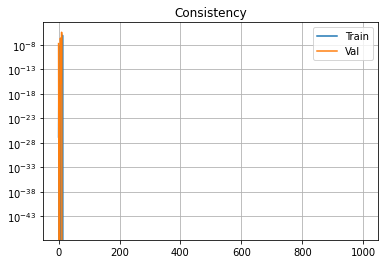

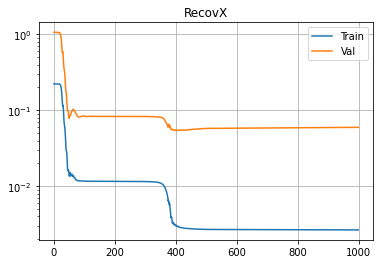

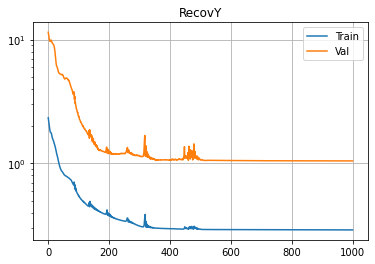

In [47]:
titles = ["Consistency", "RecovX", "RecovY", "CCM Consistency"]

for i in range(train_history.shape[1]):
  plt.title(titles[i])
  plt.plot(train_history[:, i], label="Train")
  plt.plot(val_history[:, i], label="Val")

  plt.yscale('log')
  plt.grid(True)
  plt.legend()
  plt.show()

### Получение предсказаний

In [12]:
pls_ae.load("./pretrained_models/pls_ae")

lin_solver = RidgeCV(alphas=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1], cv=3)
prediction_model = SMapLegacy(libsize=libsize,
                              predsize=predsize,
                              theta=THETA,
                              solver=lin_solver)

preds = pls_ae.predict(video_data[:libsize+predsize, :],
                       devices_data[:libsize+predsize, :],
                       prediction_model)
preds = preds.detach()
torch.save(preds, f"./preds/{SUBDIR}/pls_ae.pt")

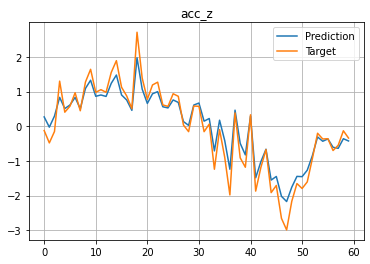

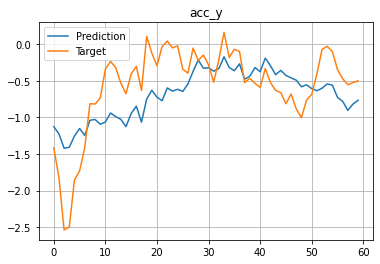

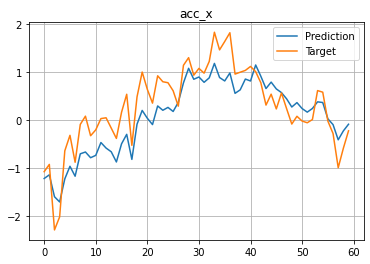

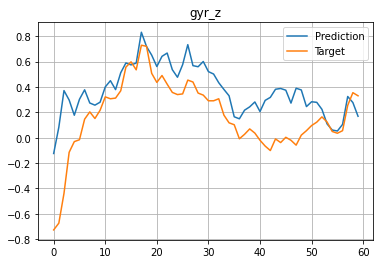

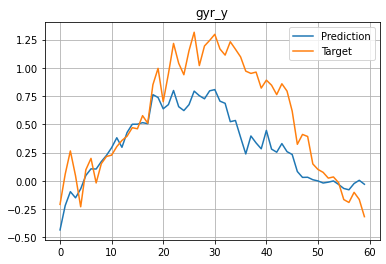

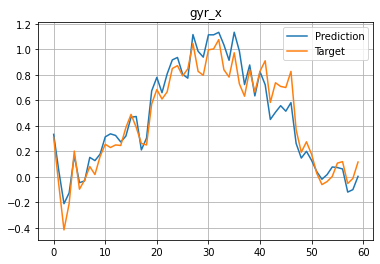

In [13]:
for i in range(6):
  plt.plot(preds[:, i], label="Prediction")
  plt.plot(devices_data[libsize:libsize+predsize, i], label="Target")
  plt.title(TARGET_COLUMNS[i])

  plt.grid(True)
  plt.legend()
  plt.show()

## PLS-CCM

### Инициализация модели

In [16]:
video_features = video_data.shape[1]
dev_features = devices_data.shape[1]
hidden_features = 5

video_encoder = nn.Sequential(
    nn.Linear(video_features, hidden_features),
    nn.LeakyReLU(),
    nn.Linear(hidden_features, hidden_features),
    nn.LeakyReLU(),
    nn.Linear(hidden_features, hidden_features)
)

video_decoder = nn.Sequential(
    nn.Linear(hidden_features, hidden_features),
    nn.LeakyReLU(),
    nn.Linear(hidden_features, hidden_features),
    nn.LeakyReLU(),
    nn.Linear(hidden_features, video_features)
)

devices_encoder = nn.Sequential(
    nn.Linear(dev_features, hidden_features),
    nn.LeakyReLU(),
    nn.Linear(hidden_features, hidden_features),
    nn.LeakyReLU(),
    nn.Linear(hidden_features, hidden_features)
)

devices_decoder = nn.Sequential(
    nn.Linear(hidden_features, hidden_features),
    nn.LeakyReLU(),
    nn.Linear(hidden_features, hidden_features),
    nn.LeakyReLU(),
    nn.Linear(hidden_features, dev_features)
)

video_autoencoder = AutoEncoder(video_encoder, video_decoder)
dev_autoencoder = AutoEncoder(devices_encoder, devices_decoder)

source_dict = {'train': video_data[:libsize, :],
               'val': video_data[libsize:libsize+predsize, :]}
target_dict = {'train': devices_data[:libsize, :],
               'val': devices_data[libsize:libsize+predsize, :]}

temp_scheduler = TemperatureScheduler()
pls_ccm = PLS_CCM(video_autoencoder,
                 dev_autoencoder,
                 source_dict,
                 target_dict,
                 CanonicalCCM(temp_scheduler))

In [17]:
optimizer = optim.Adam(chain(video_autoencoder.parameters(), dev_autoencoder.parameters()),
                       lr=0.02)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

trainer = PLS_CCMTrainer(n_epochs=1000,
                         recov_x_coef=1e-4,
                         recov_y_coef=1000,
                         consist_coef=1e-4,
                         additional_coef=20,
                         dir_to_save_model="./pretrained_models/",
                         optimizer=optimizer,
                         lr_scheduler=lr_scheduler)

### Обучение модели

In [20]:
train_ccm_history, val_ccm_history = trainer.fit(pls_ccm,
                                                 source_dict,
                                                 target_dict,
                                                 train_iterator,
                                                 val_iterator)

### Отрисовка графиков

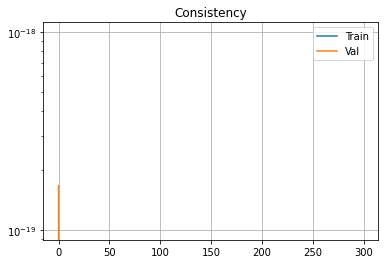

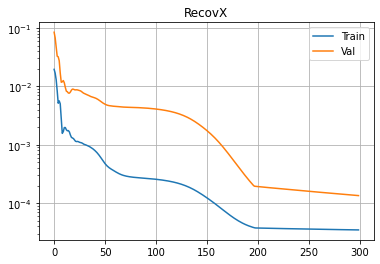

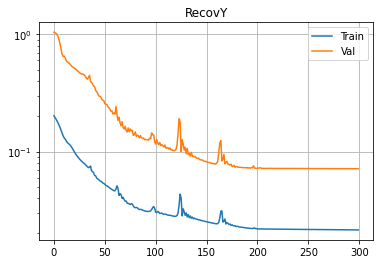

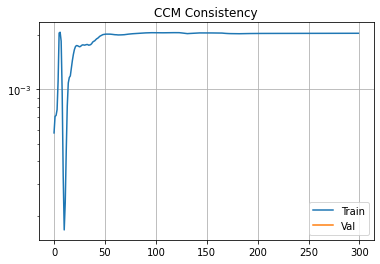

In [21]:
titles = ["Consistency", "RecovX", "RecovY", "CCM Consistency"]

for i in range(train_ccm_history.shape[1]):
  plt.title(titles[i])
  plt.plot(train_ccm_history[:, i], label="Train")
  plt.plot(val_ccm_history[:, i], label="Val")

  plt.yscale('log')
  plt.grid(True)
  plt.legend()
  plt.show()

### Получение предсказаний

In [22]:
pls_ccm.load("./pretrained_models/pls_ccm")

lin_solver = RidgeCV(alphas=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1], cv=3)
prediction_model = SMapLegacy(libsize=libsize,
                              predsize=predsize,
                              theta=THETA,
                              solver=lin_solver)

ccm_preds = pls_ccm.predict(video_data[:libsize+predsize, :],
                            devices_data[:libsize+predsize, :],
                            prediction_model)
ccm_preds = ccm_preds.detach()
torch.save(ccm_preds, f"./preds/{SUBDIR}/pls_ccm.pt")

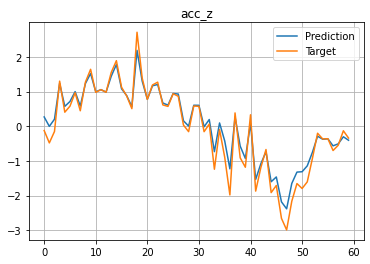

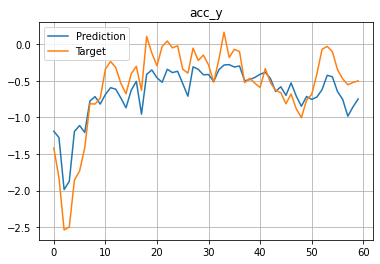

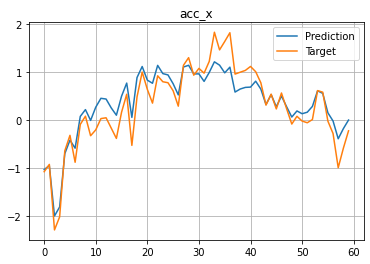

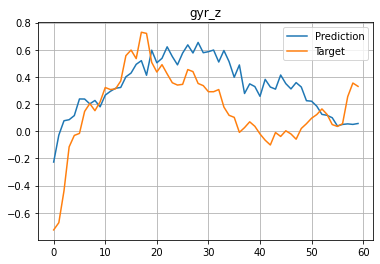

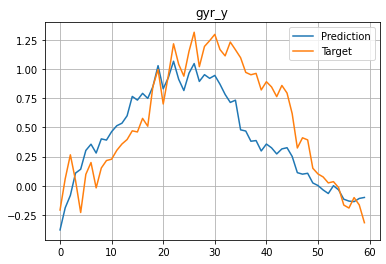

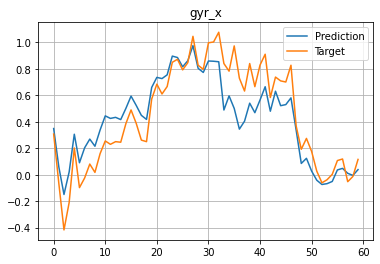

In [23]:
for i in range(6):
  plt.plot(ccm_preds[:, i], label="Prediction")
  plt.plot(devices_data[libsize:libsize+predsize, i], label="Target")
  plt.title(TARGET_COLUMNS[i])

  plt.grid(True)
  plt.legend()
  plt.show()

## PLS

### Обучение модели

In [24]:
pls = PLS(n_components=hidden_features)

pls.fit(video_data[:libsize, :],
        devices_data[:libsize, :])

### Получение предсказаний

In [25]:
lin_solver = RidgeCV(alphas=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1], cv=5)
prediction_model = SMapLegacy(libsize=libsize,
                              predsize=predsize,
                              theta=4,
                              solver=lin_solver)

pls_preds = pls.predict(video_data[:libsize+predsize, :],
                        devices_data[:libsize+predsize, :],
                        prediction_model)

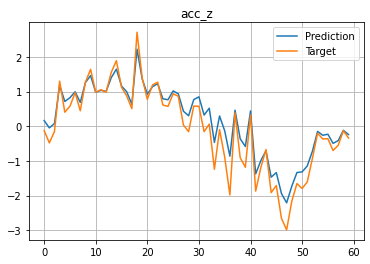

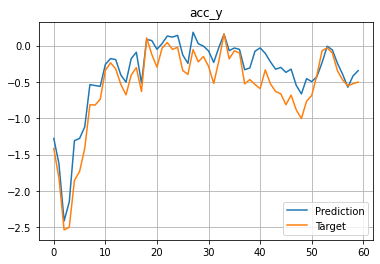

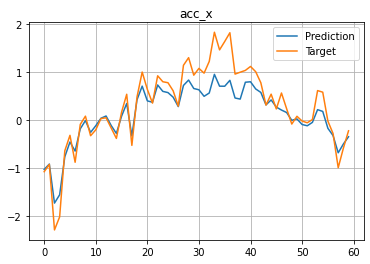

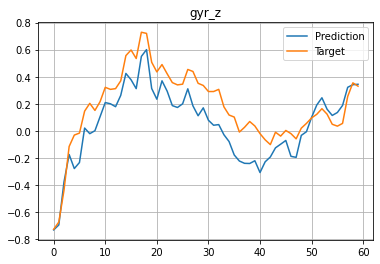

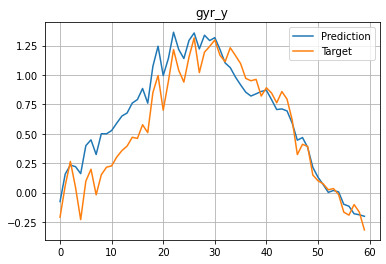

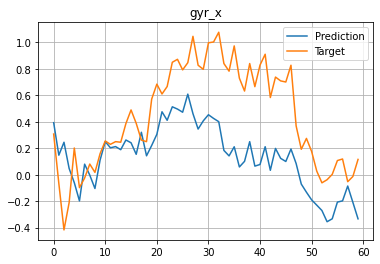

In [26]:
for i in range(6):
  plt.plot(pls_preds[:, i], label="Prediction")
  plt.plot(devices_data[libsize:libsize+predsize, i], label="Target")
  plt.title(TARGET_COLUMNS[i])

  plt.grid(True)
  plt.legend()
  plt.show()

In [27]:
pls_ae_sum = torch.sum(torch.square(preds - devices_data[libsize:libsize+predsize]), dim=0)
pls_ccm_sum = torch.sum(torch.square(ccm_preds - devices_data[libsize:libsize+predsize]), dim=0)
pls_sum = torch.sum(torch.square(pls_preds - devices_data[libsize:libsize+predsize]), dim=0)

print(pls_ae_sum)
print(pls_ccm_sum)
print(pls_sum)

tensor([ 5.8028, 12.0684, 12.3931,  4.2107,  7.5024,  0.7014])
tensor([4.1359, 5.4969, 5.4734, 4.2747, 5.5135, 1.7928])
tensor([ 7.8547,  3.4311,  7.1065,  1.6429,  2.0281, 10.2203])
